In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader import data
from datetime import datetime

import quandl
from scipy import stats
from scipy.stats import probplot
import math as m
import os
from scipy.stats import norm

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import plotly.express as px
from itertools import product
import warnings
import statsmodels.api as sm
plt.style.use('seaborn-darkgrid')

In [2]:
today = datetime(2022,4,1)
year_ago = datetime(today.year-1, today.month, today.day)

In [3]:
company_list = ['TSLA']

In [4]:
for company in company_list:
    globals()[company] = data.DataReader(company, 'yahoo', year_ago, today)

In [5]:
MA_days = [10, 20, 30]

for ma in MA_days:
    ma_str = "MA: {}".format(ma)
    TSLA[ma_str] = TSLA['Adj Close'].rolling(ma).mean()

In [6]:
TSLA.head()

,High,Low,Open,Close,Volume,Adj Close,MA: 10,MA: 20,MA: 30
Date,,,,,,,,,
2021-03-31,672.000000,641.109985,646.619995,667.929993,33337300,667.929993,NaN,NaN,NaN
2021-04-01,692.419983,659.419983,688.369995,661.750000,35298400,661.750000,NaN,NaN,NaN
2021-04-05,708.159973,684.700012,707.710022,691.049988,41842800,691.049988,NaN,NaN,NaN
2021-04-06,696.549988,681.369995,690.299988,691.619995,28271800,691.619995,NaN,NaN,NaN
2021-04-07,691.380005,667.840027,687.000000,670.969971,26309400,670.969971,NaN,NaN,NaN


In [7]:
def plot_graphic(company, company_string):
    plt.figure(figsize=(15, 6))
    plt.plot(company['Adj Close'])
    plt.plot(company['MA: 10'])
    plt.plot(company['MA: 20'])
    plt.plot(company['MA: 30'])
    
    plt.title(company_string)
    plt.xlabel('Date')
    plt.ylabel('Price')

    plt.legend(('Adj Close','MA: 10', 'MA: 20', 'MA:30'))
    plt.grid()
    plt.show()

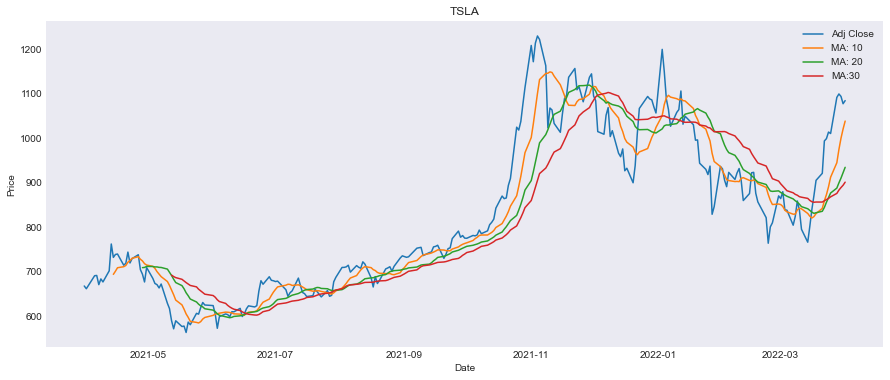

In [8]:
data_list = [TSLA]

for i in range(len(data_list)):   
    plot_graphic(data_list[i], company_list[i])

In [9]:
TSLA.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 255 entries, 2021-03-31 to 2022-04-01
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       255 non-null    float64
 1   Low        255 non-null    float64
 2   Open       255 non-null    float64
 3   Close      255 non-null    float64
 4   Volume     255 non-null    int64  
 5   Adj Close  255 non-null    float64
 6   MA: 10     246 non-null    float64
 7   MA: 20     236 non-null    float64
 8   MA: 30     226 non-null    float64
dtypes: float64(8), int64(1)
memory usage: 19.9 KB


In [10]:
print('Dataset Shape: ',  TSLA.shape)

Dataset Shape:  (255, 9)


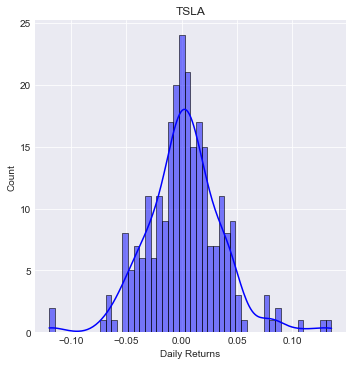

In [11]:
# Calculate returns and draw distribution

for i in range(len(data_list)):
    data_list[i]['Daily Returns'] = data_list[i]['Adj Close'].pct_change()
    sns.displot(data_list[i]['Daily Returns'].dropna(), bins=50, color='blue', kde=True)
    plt.title(company_list[i])
    plt.show()

In [12]:
# Create dataframe with stock returns
stock_returns = pd.DataFrame(data=np.array([data['Daily Returns'] for data in data_list]).T, columns=company_list)
stock_returns.tail()

,TSLA
250,0.080345
251,0.007080
252,-0.005075
253,-0.014982
254,0.006487


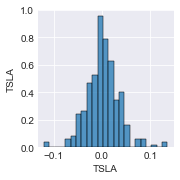

In [13]:
sns.pairplot(stock_returns.dropna())

In [14]:
def draw_jointplot(data):
    grid = sns.PairGrid(data.dropna())
    grid.map_diag(sns.histplot, bins=40, kde=True)
    grid.map_lower(sns.regplot)
    grid.map_upper(sns.kdeplot)

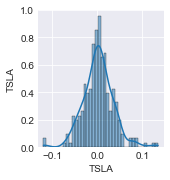

In [15]:
draw_jointplot(stock_returns)

In [16]:
mean_income = stock_returns.mean() # Mean income for each stock
cov_returns = stock_returns.cov() # Covariation 
count = len(stock_returns.columns)
print(mean_income, cov_returns, sep='\n')

TSLA    0.002475
dtype: float64
         TSLA
TSLA  0.00114


In [17]:
#calculating missing values in the dataset

missing_values = TSLA.isnull().sum()
missing_per = (missing_values/TSLA.shape[0])*100
missing_table = pd.concat([missing_values,missing_per], axis=1, ignore_index=True) 
missing_table.rename(columns={0:'Total Missing Values',1:'Missing %'}, inplace=True)
missing_table

,Total Missing Values,Missing %
High,0,0.000000
Low,0,0.000000
Open,0,0.000000
Close,0,0.000000
Volume,0,0.000000
Adj Close,0,0.000000
MA: 10,9,3.529412
MA: 20,19,7.450980
MA: 30,29,11.372549
Daily Returns,1,0.392157


In [18]:
def fill_missing(df):
    ### function to impute missing values using interpolation ###
    df['Open'] = df['Open'].interpolate()
    df['Close'] = df['Close'].interpolate()
    df['Adj Close'] = df['Adj Close'].interpolate()

    df['Volume'] = df['Volume'].interpolate()
    df['High'] = df['High'].interpolate()
    df['Low'] = df['Low'].interpolate()

    print(df.head())
    print(df.isnull().sum())

In [19]:
fill_missing(TSLA)

                  High         Low        Open       Close    Volume  \
Date                                                                   
2021-03-31  672.000000  641.109985  646.619995  667.929993  33337300   
2021-04-01  692.419983  659.419983  688.369995  661.750000  35298400   
2021-04-05  708.159973  684.700012  707.710022  691.049988  41842800   
2021-04-06  696.549988  681.369995  690.299988  691.619995  28271800   
2021-04-07  691.380005  667.840027  687.000000  670.969971  26309400   

             Adj Close  MA: 10  MA: 20  MA: 30  Daily Returns  
Date                                                           
2021-03-31  667.929993     NaN     NaN     NaN            NaN  
2021-04-01  661.750000     NaN     NaN     NaN      -0.009252  
2021-04-05  691.049988     NaN     NaN     NaN       0.044277  
2021-04-06  691.619995     NaN     NaN     NaN       0.000825  
2021-04-07  670.969971     NaN     NaN     NaN      -0.029857  
High              0
Low               0
Open   

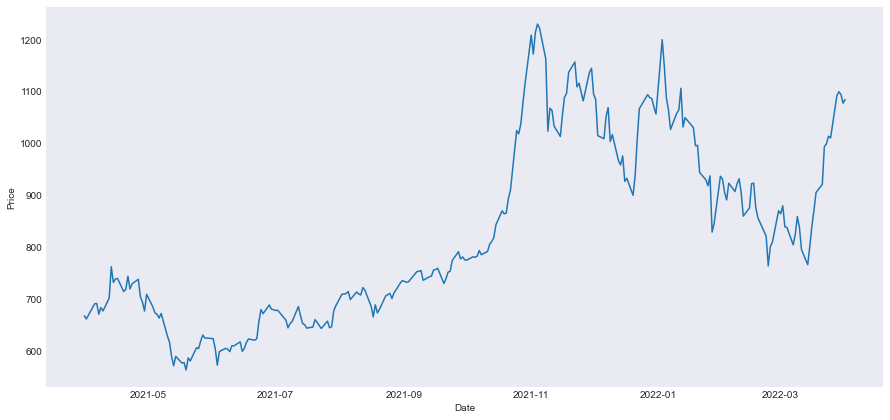

In [20]:
plt.figure(figsize=(15, 7))
plt.plot(TSLA['Adj Close'])
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid()
plt.show()

In [21]:
#calculating missing values in the dataset

missing_values = TSLA.isnull().sum()
missing_per = (missing_values/TSLA.shape[0])*100
missing_table = pd.concat([missing_values,missing_per], axis=1, ignore_index=True) 
missing_table.rename(columns={0:'Total Missing Values',1:'Missing %'}, inplace=True)
missing_table

,Total Missing Values,Missing %
High,0,0.000000
Low,0,0.000000
Open,0,0.000000
Close,0,0.000000
Volume,0,0.000000
Adj Close,0,0.000000
MA: 10,9,3.529412
MA: 20,19,7.450980
MA: 30,29,11.372549
Daily Returns,1,0.392157


In [23]:
var = stock_returns.var()
var

TSLA    0.00114
dtype: float64

In [24]:
sigma = (np.sqrt(float(var)))

sigma

0.033764485044763926

In [25]:
S0 = 667.929993 # Stock price
K1 = 900 # Strike price
T = 1 # Time till expiration (in years)
r = 0.0428 # Risk-free interest rate
var = stock_returns.var()  
sigma = (np.sqrt(float(var))) # Volatility (standard deviation)

In [26]:
from scipy.stats import qmc
sampler = qmc.Halton(d=1, scramble=False)
sample = sampler.random(n=100)


In [29]:
St = 0
for i in range (0,100):
    St = S0*np.exp((r-((sigma**2)/2))*T+ sigma*np.sqrt(T)*sample[i][0])
print(St)

715.1755705897285


In [30]:
call = 0

for i in range (0,100):
    St = S0*np.exp((r-((sigma**2)/2))*T+ sigma*np.sqrt(T)*sample[i][0])
    b = max(0,(St-K1))
    call += np.exp(-r) * b
    
    
call = call/100
print(call)

0.0


In [31]:
put = 0

for i in range (0,100):
    St = S0*np.exp((r-((sigma**2)/2))*T+ sigma*np.sqrt(T)*sample[i][0])
    b = max(0,(K1-St))
    put += np.exp(-r) * b
    
    
put = put/100
print(put)

183.61065279744707
